# Analyzer of Stocks


## Libraries


In [1]:
# Import necessary libraries
from dotenv import load_dotenv
from libs import indicators
import alpaca_trade_api as trade_api
import os
import pandas as pd


## Alpaca Connection


In [2]:
load_dotenv()


True

In [3]:
# Get keys and URL for Alpaca API
alpaca_key = os.getenv('APCA_API_KEY_ID')
alpaca_secret_key = os.getenv('APCA_API_SECRET_KEY')
alpaca_paper_trade_url = os.getenv('APCA_API_PAPER_URL')


In [4]:
# Instantiate Alpaca connection
alpaca = trade_api.REST(alpaca_key, alpaca_secret_key, base_url=alpaca_paper_trade_url)


In [5]:
# Default parameters
ticker = 'TWOU'

today = pd.Timestamp('today')
today_date = f'{today:%Y-%m-%d}'

start_date = pd.Timestamp('2020-01-01', tz='America/New_York').isoformat()

end_date = pd.Timestamp(today_date, tz='America/New_York').isoformat()

timeframe = '1D'


In [6]:
# Get dataframe of ticker data
df_ohlcv_original = alpaca.get_barset(ticker, timeframe, start=start_date, end=end_date).df

# Copy of original dataframe
df_ohlcv = df_ohlcv_original[ticker].copy()


## Bollinger Bands


In [7]:
# Bollinger Band configuration
bollinger_band_window = 20
num_standard_deviation = 2

# Generate Bollinger Band data
df_updated = indicators.bollinger_band_generator(df_ohlcv, 'close', bollinger_band_window, num_standard_deviation)


<AxesSubplot:title={'center':'TWOU Bollinger Bands'}, xlabel='Date', ylabel='Price (USD)'>

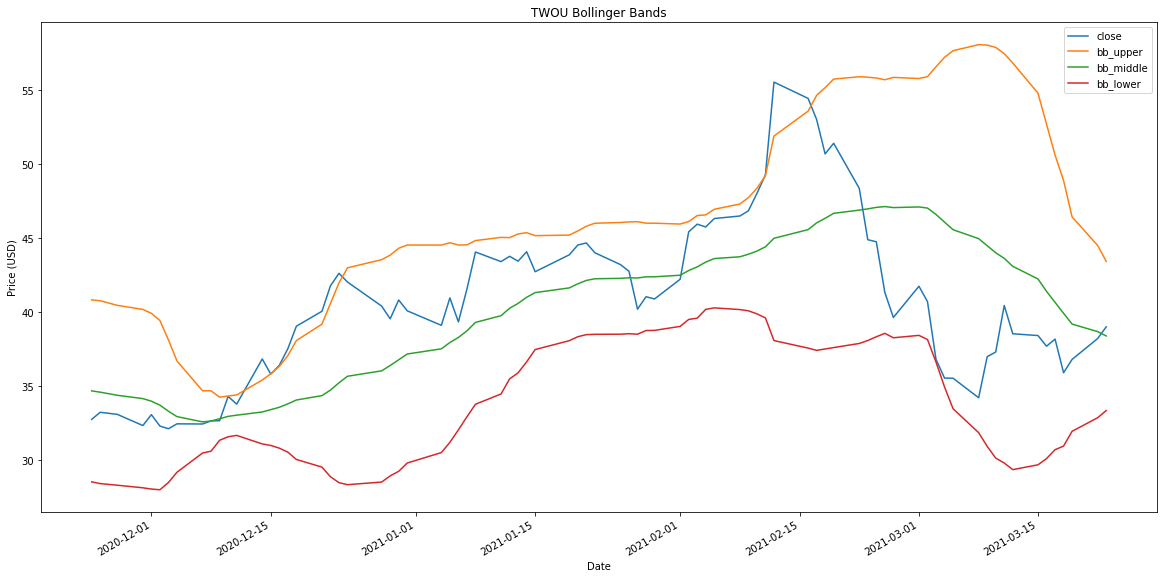

In [8]:
df_updated[['close', 'bb_upper', 'bb_middle', 'bb_lower']].plot(figsize=(20,10), title=f'{ticker} Bollinger Bands', xlabel='Date', ylabel='Price (USD)')


## Keltner Channels


In [9]:
# Generate average true range values
test1 = indicators.average_true_range_generator(df_updated)
test1


,open,high,low,close,volume,bb_middle,bb_upper,bb_lower,atr,other_atr
time,,,,,,,,,,
2020-11-24 00:00:00-05:00,34.01,34.305,32.25,32.750,944400,34.67500,40.815391,28.534609,NaN,NaN
2020-11-25 00:00:00-05:00,32.78,33.590,32.10,33.230,837312,34.58800,40.760017,28.415983,NaN,NaN
2020-11-27 00:00:00-05:00,33.67,33.931,32.61,33.090,548672,34.37850,40.449394,28.307606,NaN,NaN
2020-11-30 00:00:00-05:00,33.44,33.910,31.86,32.335,1123546,34.15375,40.175127,28.132373,NaN,NaN
2020-12-01 00:00:00-05:00,32.57,33.630,32.15,33.070,1000363,33.98025,39.911415,28.049085,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-03-17 00:00:00-04:00,37.25,38.790,36.21,38.170,1233887,40.65100,50.599509,30.702491,3.172066,3.065998
2021-03-18 00:00:00-04:00,36.38,37.850,35.76,35.900,1722342,39.91250,48.873291,30.951709,3.061348,2.965386
2021-03-19 00:00:00-04:00,35.94,37.120,35.11,36.800,1838363,39.18300,46.419111,31.946889,2.958325,2.871505
